## activation_visualization

We implemented activation visualization using SAE on LLava-Mistral 7B, enabling us to separately compute the l0 of SAE on text tokens and image tokens.

In [1]:
import os
import pdb
from typing import Any, cast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from PIL import Image
from sae_lens import SAE
from torchvision.transforms.functional import to_pil_image
from transformer_lens.HookedLlava import HookedLlava
from transformer_lens import HookedChameleon
from transformers import LlavaNextForConditionalGeneration, LlavaNextProcessor
from transformers import ChameleonForConditionalGeneration, AutoTokenizer, ChameleonProcessor
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)
import seaborn as sns
from sae_lens.activation_visualization import load_llava_model, load_chameleon_model,load_sae,prepare_input,generate_with_saev,map_patches_to_image,overlay_activation_on_image

Model loading

In [ ]:
MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
model_path = "/mnt/data/changye/model/llava"
device = "cuda:5"
sae_device = "cuda:6"
sae_path = "/mnt/data/changye/checkpoints/xepk4xea/final_163840000"
dataset_path = "/mnt/data/changye/data/obelics3k-tokenized-llava4096"
columns_to_read = ["input_ids", "pixel_values", "attention_mask", "image_sizes"]

save_path = "/home/saev/changye/SAELens-V/activation_visualization"


(
        processor,
        vision_model,
        vision_tower,
        multi_modal_projector,
        hook_language_model,
) = load_llava_model(MODEL_NAME, model_path, device)

sae = load_sae(sae_path, sae_device)





Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model llava-hf/llava-v1.6-mistral-7b-hf into HookedTransformer


/home/saev/changye/SAELens-V/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Input loading

In [3]:
example_prompt = "What is shown in the image?"
# example_prompt = " "
image_path = "/home/saev/changye/SAELens-V/image_source/R.jpg"
inputs, image = prepare_input(processor,device, image_path, example_prompt)
print(inputs['input_ids'])
# i, j = 0, 5

# input_ids = inputs['input_ids']

# tmp=input_ids[0, j].clone()
# tensor_without_element = torch.cat([input_ids[0, :j], input_ids[0,(j+1):]])
# input_ids = torch.cat([tensor_without_element[:i],tmp.unsqueeze(0),tensor_without_element[i:]])
# inputs['input_ids']=input_ids.unsqueeze(0)
# print(inputs['input_ids'])

tensor([[    1,   733, 16289, 28793,  1824,   349,  4894,   297,   272,  3469,
         28804, 32000, 28705,   733, 28748, 16289, 28793]], device='cuda:5')


Generate

In [4]:
total_activation_l1_norms_list,patch_features_list,feature_act_list,image_indice=generate_with_saev(
        inputs, hook_language_model, processor, save_path, image, sae, sae_device
    )
feature_act_list=[feature_act[0] for feature_act in feature_act_list]
print(feature_act_list[0].shape)

  0%|          | 0/30 [00:00<?, ?it/s]

[INST] What is shown in the image?  [/INST] In the image, we see a lively scene of a group of children, most likely boys, playing basketball. They are wearing purple and white uniform
torch.Size([1192, 65536])


In [91]:
print(image_indice)

tensor([   5,    6,    7,  ..., 1178, 1179, 1180])


Activation Visualization

In [5]:
current_activation_map = map_patches_to_image(total_activation_l1_norms_list[0],max_val=1000)
final_image = overlay_activation_on_image(image, current_activation_map,alpha=128)
final_image.save(os.path.join(save_path, f"result.png"))

In [6]:
text_act_list = []
for feature_act in feature_act_list:
    all_indices = torch.arange(feature_act.shape[0])
    combined_indices = torch.cat((all_indices,image_indice))
    unique,counts=torch.unique(combined_indices,return_counts=True)
    difference = unique[counts == 1]
    # print(all_indices.shape)
    # print(combined_indices.shape)
    # print(difference)
    text_act_list.append(feature_act[difference])

In [ ]:
# text_act_count_list=[(text_act!=0).sum(1) for text_act in text_act_list]
# print(text_act_count_list[0].shape)

torch.Size([16])


Global Activation

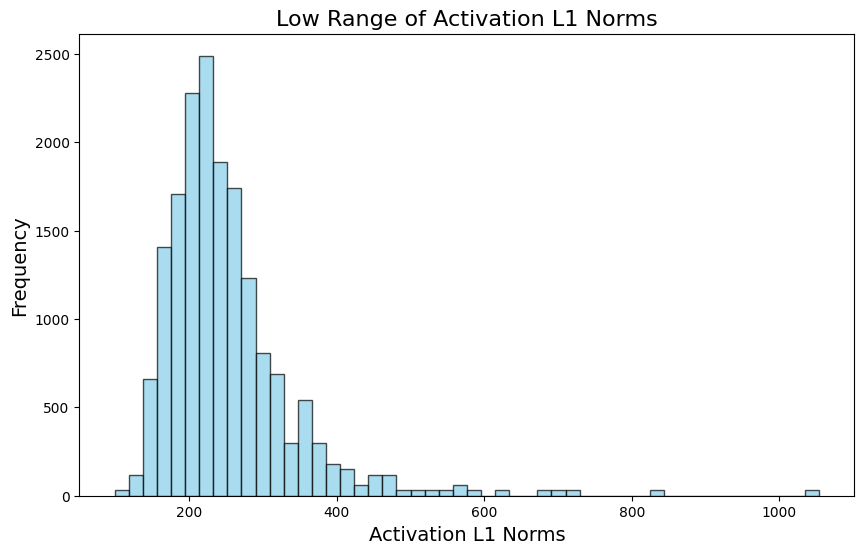

high_values [259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128
 259735.06     1672.4131 259735.08     1672.4128 259735.06     1672.4127
 259735.06     1672.4128 259735.06     1672.4131 259735.08     1672.4128
 259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128
 259735.06     1672.4131 259735.08     1672.4128 259735.06     1672.4127
 259735.06     1672.4128 259735.06     1672.4131 259735.08     1672.4128
 259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128]


In [ ]:
global_activation_l1_norms = torch.cat(total_activation_l1_norms_list)

global_activation_l1_norms_flat = global_activation_l1_norms.flatten()


global_activation_l1_norms_np = global_activation_l1_norms_flat.cpu().numpy()

min_value = global_activation_l1_norms_np.min()
if min_value <= 0:
    shift = abs(min_value) + 1e-6
    global_activation_l1_norms_np_shifted = global_activation_l1_norms_np + shift
else:
    global_activation_l1_norms_np_shifted = global_activation_l1_norms_np

low_values = global_activation_l1_norms_np[global_activation_l1_norms_np < 1500]
high_values = global_activation_l1_norms_np[global_activation_l1_norms_np >= 1500]

plt.figure(figsize=(10, 6))
plt.hist(low_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Low Range of Activation L1 Norms', fontsize=16)
plt.xlabel('Activation L1 Norms', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

print("high_values",high_values)

# plt.figure(figsize=(10, 6))
# plt.hist(high_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('High Range of Activation L1 Norms', fontsize=16)
# plt.xlabel('Activation L1 Norms', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.show()

In [10]:
print(high_values.shape)

(60,)


In [ ]:
# patch_indices = torch.stack(
#         (valid_indices[:576], valid_indices[576:]), dim=1
#     )
#     patch_features = feature_acts[:, patch_indices]
l0_feature_list = []
for patch_feature in patch_features_list:
    patch_feature=(patch_feature!=0).sum(-1)
    patch_feature=patch_feature.sum(-1)
    l0_feature_list.append(patch_feature)
print(l0_feature_list[0].shape)
global_activation_l0_norms = torch.stack(l0_feature_list).sum(0)/len(l0_feature_list)
print(global_activation_l0_norms.shape)


torch.Size([576])
torch.Size([576])
